## Import Libraries

In [2]:
'''basics'''
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import pickle5 as pickle
import numpy as np

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB


'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')


# Forest

## Import data and holdout data for prediction

In [3]:
df = pd.read_excel('../data/processed/encoded_labels/Forest.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'forest', 'tropical_forests', 'temperate_forests', 'dryland_forests',
       'montane_forests', 'intact_forests', 'boreal_forests_taiga_forests'],
      dtype='object')

In [10]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'forest'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,tropical_forests,38
1,temperate_forests,4
2,dryland_forests,14
3,montane_forests,17
4,intact_forests,7
5,boreal_forests_taiga_forests,1


Text(0.5, 0, 'category')

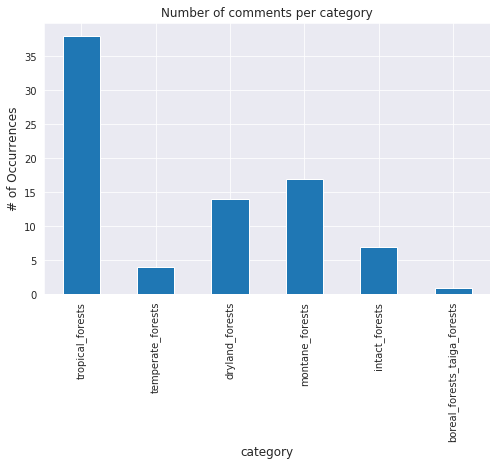

In [11]:
df_stats.plot(x='category', y='number_of_inputs', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## How many comments have multi labels

Text(0.5, 0, '# of categories')

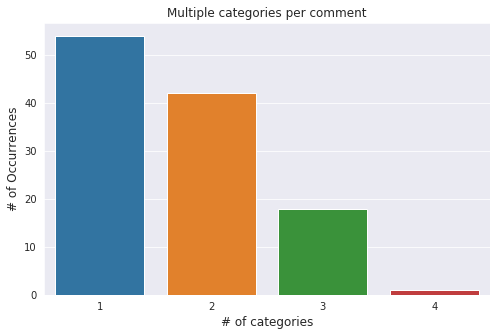

In [12]:
rowsums = df.iloc[:,4:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

## The distribution of the number of words in input texts

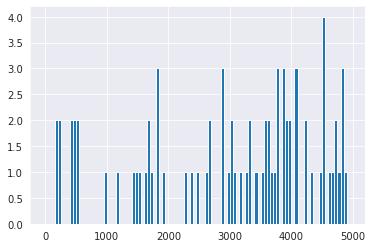

In [13]:
lens = df.all_text_clean.str.len()
lens.hist(bins = np.arange(0,5000,50))

## Holding out 5 rows from the original dataframe for prediction at the end

In [14]:
df_holdout = df.iloc[:5]

df = df.iloc[5:]

In [15]:
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'forest', 'tropical_forests', 'temperate_forests', 'dryland_forests',
       'montane_forests', 'intact_forests', 'boreal_forests_taiga_forests'],
      dtype='object')

##  Features engineering

In [16]:
categories = ['tropical_forests', 'temperate_forests', 'dryland_forests',
       'montane_forests', 'intact_forests', 'boreal_forests_taiga_forests']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)


## Train multiple ML models / OneVsRest multi-label strategy

In [17]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]
#print (tabulate(rows, header, tablefmt='html'))


<table>
<thead>
<tr><th>Category                    </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>tropical_forests            </td><td style="text-align: right;">       38</td><td>K Nearest Neighbor    
 AdaBoost    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Decsision Tree    
 Random Forest              </td><td>0.696969696969697    
 0.6363636363636364    
 0.6363636363636364    
 0.6666666666666666    
 0.48484848484848486    
 0.6363636363636364                 </td><td>0.6930147058823529   
 0.5833333333333333   
 0.5833333333333333   
 0.6666666666666666   
 0.4027777777777778   
 0.3181818181818182                  </td><td>0.7083333333333333    
 0.5535714285714286    
 0.5535714285714286    
 0.5595238095238095    
 0.41666666666666663    
 0.5000000000000009               </td><td>0.6898496240601504    
 0.5416666666666666    
 0.5416666666666666    
 0.5254901960784314    
 0.40634920634920635    
 0.3888888888888889           </td></tr>
<tr><td>temperate_forests           </td><td style="text-align: right;">        4</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9090909090909091    
 0.9090909090909091    
 0.9090909090909091    
 0.9090909090909091    
 0.9090909090909091    
 0.9090909090909091                 </td><td>0.45454545454545453   
 0.45454545454545453   
 0.45454545454545453   
 0.45454545454545453   
 0.45454545454545453   
 0.45454545454545453                  </td><td>0.5000000000000009    
 0.5000000000000009
 0.5000000000000009    
 0.5000000000000009    
 0.5000000000000009    
 0.5000000000000009               </td><td>0.47619047619047616    
 0.47619047619047616    
 0.47619047619047616    
 0.47619047619047616    
 0.47619047619047616    
 0.47619047619047616           </td></tr>
<tr><td>dryland_forests             </td><td style="text-align: right;">       14</td><td>Random Forest    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost    
 Gaussian Naive Bayes    
 Decsision Tree              </td><td>0.9090909090909091    
 0.9090909090909091    
 0.8787878787878788    
 0.8787878787878788    
 0.8787878787878788    
 0.7878787878787878                 </td><td>0.45454545454545453   
 0.45454545454545453   
 0.4531250000000009
 0.4531250000000009
 0.4531250000000009
 0.4482758620689655                  </td><td>0.5000000000000009    
 0.5000000000000009    
 0.48333333333333334    
 0.48333333333333334    
 0.48333333333333334    
 0.43333333333333335               </td><td>0.47619047619047616    
 0.47619047619047616    
 0.46774193548387094    
 0.46774193548387094    
 0.46774193548387094    
 0.44067796610169496           </td></tr>
<tr><td>montane_forests             </td><td style="text-align: right;">       17</td><td>Random Forest    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Decsision Tree    
 AdaBoost              </td><td>0.9393939393939394    
 0.9393939393939394    
 0.9090909090909091    
 0.8787878787878788    
 0.8181818181818182    
 0.8787878787878788                 </td><td>0.968750000000
 0.9687500000000009
 0.717741935483871   
 0.6333333333333333   
 0.5642857142857143   
 0.4531250000000009        </td><td>0.6666666666666666    
 0.6666666666666666    
 0.6500000000000009    
 0.6333333333333333    
 0.6000000000000009    
 0.48333333333333334               </td><td>0.7338709677419355    
 0.7338709677419355    
 0.6754098360655738    
 0.6333333333333333    
 0.5732758620689655    
 0.46774193548387094           </td></tr>
<tr><td>intact_forests              </td><td style="text-align: right;">        7</td><td>Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree    
 AdaBoost              </td><td>0.9090909090909091    
 0.9090909090909091    
 0.9090909090909091    
 0.9090909090909091    
 0.8787878787878788    
 0.8787878787878788                 </td><td>0.45454545454545453   
 0.45454545454545453   
 0.45454545454545453   
 0.45454545454545453   
 0.4531250000000009
 0.4531250000000009        </td><td>0.5000000000000009    
 0.5000000000000009    
 0.5000000000000009    
 0.5000000000000009    
 0.48333333333333334    
 0.48333333333333334               </td><td>0.47619047619047616    
 0.47619047619047616    
 0.47619047619047616    
 0.47619047619047616    
 0.46774193548387094    
 0.46774193548387094           </td></tr>
<tr><td>boreal_forests_taiga_forests</td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 AdaBoost              </td><td>1.000000000000000    
 1.000000000000000    
 1.000000000000000    
 1.000000000000000    
 1.000000000000000    
 0.9393939393939394                 </td><td>1.000000000000000   
 1.000000000000000   
 1.0000000000000000   
 1.0000000000000000   
 1.0000000000000000   
 0.5000000000000009                 </td><td>1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 0.4696969696969697               </td><td>1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 0.4843750000000000           </td></tr>
</tbody>
</table>

# tundra

In [21]:
df = pd.read_excel('../data/processed/encoded_labels/Tundra.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'tundra', 'alpine_tundra'],
      dtype='object')

In [23]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'tundra'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,alpine_tundra,1


# conserved_areas

In [24]:
df = pd.read_excel('../data/processed/encoded_labels/Conserved_Areas.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'conserved_areas', '_indigenous_protected_and_conserved_areas_ipcas_x',
       '_indigenous_protected_and_conserved_areas_ipcas_y',
       'marine_and_coastal_protected_areas', 'terrestrial_protected_areas',
       'indigenous_and_communities_conserved_areas_icca',
       'transboundary_conservation_areas', 'productive_landscapes_seascapes',
       'key_biodiversity_areas_kba',
       '_important_bird_and_biodiversity_areas_ibas',
       'specially_protected_areas_spas',
       '_indigenous_protected_and_conserved_areas_ipcas',
       'protected_areas_network',
       'oecm_other_effective_area_based_conservation_measures',
       'locally_managed_marine_areas'],
      dtype='object')

In [26]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'conserved_areas'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,_indigenous_protected_and_conserved_areas_ipcas_x,2
1,_indigenous_protected_and_conserved_areas_ipcas_y,1
2,marine_and_coastal_protected_areas,48
3,terrestrial_protected_areas,76
4,indigenous_and_communities_conserved_areas_icca,23
5,transboundary_conservation_areas,12
6,productive_landscapes_seascapes,56
7,key_biodiversity_areas_kba,51
8,_important_bird_and_biodiversity_areas_ibas,12
9,specially_protected_areas_spas,14


In [29]:
categories = ['_indigenous_protected_and_conserved_areas_ipcas_x',
       '_indigenous_protected_and_conserved_areas_ipcas_y',
       'marine_and_coastal_protected_areas', 'terrestrial_protected_areas',
       'indigenous_and_communities_conserved_areas_icca',
       'transboundary_conservation_areas', 'productive_landscapes_seascapes',
       'key_biodiversity_areas_kba',
       '_important_bird_and_biodiversity_areas_ibas',
       'specially_protected_areas_spas',
       '_indigenous_protected_and_conserved_areas_ipcas',
       'protected_areas_network',
       'oecm_other_effective_area_based_conservation_measures',
       'locally_managed_marine_areas']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]
#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category                                             </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>_indigenous_protected_and_conserved_areas_ipcas_x    </td><td style="text-align: right;">        2</td><td>Random Forest    <br>
 Decsision Tree   <br> 
 Gaussian Naive Bayes <br>   
 K Nearest Neighbor <br>   
 Stochastic Gradient Descent  <br>  
 AdaBoost              </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9782608695652174    
 0.9782608695652174                 </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 0.5   <br>
 0.5       <br>           </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4891304347826087    
 0.4891304347826087               </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4945054945054945    
 0.4945054945054945           </td></tr>
<tr><td>_indigenous_protected_and_conserved_areas_ipcas_y    </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>         </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0                  </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>       </td><td>1.0  <br>  
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0           </td></tr>
<tr><td>marine_and_coastal_protected_areas                   </td><td style="text-align: right;">       48</td><td>Random Forest    
 Decsision Tree    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost    
 Gaussian Naive Bayes              </td><td>0.8913043478260869    
 0.8260869565217391    
 0.8260869565217391    
 0.8478260869565217    
 0.8043478260869565    
 0.782608695652174                 </td><td>0.9418604651162791   
 0.7083333333333333   
 0.7083333333333333   
 0.7390243902439024   
 0.6681681681681682   
 0.5916666666666667                  </td><td>0.6875    
 0.7467105263157895    
 0.7467105263157895    
 0.6611842105263157    
 0.6842105263157895    
 0.5723684210526316               </td><td>0.7418630751964086    
 0.7237237237237237    
 0.7237237237237237    
 0.6864654333008764    
 0.6752941176470588    
 0.5787545787545788           </td></tr>
<tr><td>terrestrial_protected_areas                          </td><td style="text-align: right;">       76</td><td>K Nearest Neighbor    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 Decsision Tree    
 Stochastic Gradient Descent              </td><td>0.6521739130434783    
 0.6521739130434783    
 0.6304347826086957    
 0.6086956521739131    
 0.5652173913043478    
 0.5217391304347826                 </td><td>0.6519230769230769   
 0.6646825396825397   
 0.6304347826086957   
 0.6383928571428572   
 0.5791666666666666   
 0.5625                  </td><td>0.6496212121212122    
 0.6571969696969697    
 0.6306818181818181    
 0.6174242424242424    
 0.571969696969697    
 0.5359848484848485               </td><td>0.6495238095238096    
 0.6495238095238095    
 0.630260047281324    
 0.5964912280701754    
 0.5576923076923077    
 0.47291666666666665           </td></tr>
<tr><td>indigenous_and_communities_conserved_areas_icca      </td><td style="text-align: right;">       23</td><td>Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 AdaBoost              </td><td>0.782608695652174    
 0.8260869565217391    
 0.8260869565217391    
 0.8043478260869565    
 0.8043478260869565    
 0.782608695652174                 </td><td>0.5916666666666667   
 0.6704545454545454   
 0.41304347826086957   
 0.4111111111111111   
 0.4111111111111111   
 0.4090909090909091                  </td><td>0.5723684210526316    
 0.549342105263158    
 0.5    
 0.4868421052631579    
 0.4868421052631579    
 0.47368421052631576               </td><td>0.5787545787545788    
 0.551219512195122    
 0.45238095238095233    
 0.4457831325301205    
 0.4457831325301205    
 0.43902439024390244           </td></tr>
<tr><td>transboundary_conservation_areas                     </td><td style="text-align: right;">       12</td><td>Gaussian Naive Bayes    
 Decsision Tree    
 Random Forest    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost              </td><td>0.9782608695652174    
 0.8913043478260869    
 0.9782608695652174    
 0.9782608695652174    
 0.9565217391304348    
 0.9565217391304348                 </td><td>0.75   <br>
 0.5833333333333334   
 0.4891304347826087   
 0.4891304347826087   
 0.4888888888888889   
 0.4888888888888889                  </td><td>0.9888888888888889    
 0.9444444444444444<br>    
 0.5  <br>  
 0.5    <br>
 0.4888888888888889    
 0.4888888888888889               </td><td>0.8277153558052435    
 0.6134453781512605    
 0.4945054945054945    
 0.4945054945054945    
 0.4888888888888889    
 0.4888888888888889           </td></tr>
<tr><td>productive_landscapes_seascapes                      </td><td style="text-align: right;">       56</td><td>Decsision Tree    
 Stochastic Gradient Descent    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 AdaBoost    
 Random Forest              </td><td>0.717391304347826    
 0.6956521739130435    
 0.6521739130434783    
 0.717391304347826    
 0.5869565217391305    
 0.6956521739130435                 </td><td>0.6470588235294117   
 0.6247086247086246   
 0.6024340770791075   
 0.631578947368421   
 0.5229166666666667   
 0.35555555555555557                  </td><td>0.6398601398601399    
 0.6247086247086246    
 0.6177156177156178    
 0.5932400932400932    
 0.5256410256410257    
 0.48484848484848486               </td><td>0.6429850746268657    
 0.6247086247086246    
 0.6043010752688172    
 0.5989268947015426    
 0.5216201423097975    
 0.41025641025641024           </td></tr>
<tr><td>key_biodiversity_areas_kba                           </td><td style="text-align: right;">       51</td><td>AdaBoost    
 Gaussian Naive Bayes    
 Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor              </td><td>0.6956521739130435    
 0.7391304347826086    
 0.6304347826086957    
 0.6739130434782609    
 0.7391304347826086    
 0.6086956521739131                 </td><td>0.6490872210953347   
 0.6696696696696697   
 0.6038461538461539   
 0.5906862745098039   
 0.8666666666666667   
 0.4935064935064935                  </td><td>0.6713286713286714    
 0.6317016317016317    
 0.6258741258741258    
 0.5862470862470862    
 0.5384615384615384    
 0.4941724941724942               </td><td>0.6537634408602151    
 0.6415584415584416    
 0.5983564458140729    
 0.5880597014925373    
 0.49450549450549447    
 0.49264705882352944           </td></tr>
<tr><td>_important_bird_and_biodiversity_areas_ibas          </td><td style="text-align: right;">       12</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9565217391304348                 </td><td>0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4888888888888889                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4888888888888889               </td><td>0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.4888888888888889           </td></tr>
<tr><td>specially_protected_areas_spas                       </td><td style="text-align: right;">       14</td><td>Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Decsision Tree              </td><td>0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.9347826086956522    
 0.8695652173913043                 </td><td>0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174   
 0.4777777777777778   
 0.47619047619047616                  </td><td>0.5  <br>  
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.48863636363636365    
 0.45454545454545453               </td><td>0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889    
 0.4831460674157304    
 0.46511627906976744           </td></tr>
<tr><td>_indigenous_protected_and_conserved_areas_ipcas      </td><td style="text-align: right;">        0</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0  <br>  
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>         </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0       <br>           </td><td>1.0 <br>   
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>       </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>   </td></tr>
<tr><td>protected_areas_network                              </td><td style="text-align: right;">        7</td><td>Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Decsision Tree              </td><td>0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9565217391304348    
 0.9347826086956522                 </td><td>0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4888888888888889   
 0.48863636363636365                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4888888888888889    
 0.4777777777777778               </td><td>0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.4888888888888889    
 0.4831460674157304           </td></tr>
<tr><td>oecm_other_effective_area_based_conservation_measures</td><td style="text-align: right;">       18</td><td>Random Forest    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost    
 Gaussian Naive Bayes    
 Decsision Tree              </td><td>0.9130434782608695    
 0.9130434782608695    
 0.8913043478260869    
 0.8913043478260869    
 0.8260869565217391    
 0.8043478260869565                 </td><td>0.45652173913043476   
 0.45652173913043476   
 0.45555555555555555   
 0.45555555555555555   
 0.4523809523809524   
 0.45121951219512196                  </td><td>0.5  <br>  
 0.5    <br>
 0.4880952380952381    
 0.4880952380952381    
 0.4523809523809524    
 0.44047619047619047               </td><td>0.47727272727272724    
 0.47727272727272724    
 0.47126436781609193    
 0.47126436781609193    
 0.4523809523809524    
 0.44578313253012053           </td></tr>
<tr><td>locally_managed_marine_areas                         </td><td style="text-align: right;">       15</td><td>AdaBoost    
 Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.8695652173913043                 </td><td>0.75   
 0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4878048780487805                  </td><td>0.9888888888888889    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4444444444444444               </td><td>0.8277153558052435    
 0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.46511627906976744           </td></tr>
</tbody>
</table>

# Freshwater

In [31]:
df = pd.read_excel('../data/processed/encoded_labels/Freshwater.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'freshwater', 'rivers_and_river_basins', 'lakes', 'aquifers',
       'estuaries'],
      dtype='object')

In [32]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'freshwater'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,rivers_and_river_basins,32
1,lakes,8
2,aquifers,6
3,estuaries,2


In [39]:
categories = ['rivers_and_river_basins', 'lakes', 'aquifers','estuaries']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]

#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category               </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>rivers_and_river_basins</td><td style="text-align: right;">       32</td><td>Random Forest    
 Gaussian Naive Bayes    
 AdaBoost    
 Decsision Tree    
 K Nearest Neighbor    
 Stochastic Gradient Descent              </td><td>0.6111111111111112    
 0.6111111111111112    
 0.5555555555555556    
 0.5555555555555556    
 0.5555555555555556    
 0.5555555555555556                 </td><td>0.6250000000000000   
 0.6250000000000000   
 0.5555555555555556   
 0.5584415584415584   
 0.5692307692307692   
 0.6000000000000000                  </td><td>0.6111111111111112    
 0.6111111111111112    
 0.5555555555555556    
 0.5555555555555556    
 0.5555555555555556    
 0.5555555555555556               </td><td>0.600000000000000    
 0.6000000000000000   
 0.5555555555555556    
 0.5500000000000000    
 0.5324675324675324    
 0.5000000000000000           </td></tr>
<tr><td>lakes                  </td><td style="text-align: right;">        8</td><td>Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 AdaBoost    
 Gaussian Naive Bayes              </td><td>0.8333333333333334    
 0.8888888888888888    
 0.8888888888888888    
 0.8888888888888888    
 0.8333333333333334    
 0.8333333333333334                 </td><td>0.6333333333333333   
 0.4444444444444444   
 0.4444444444444444   
 0.4444444444444444   
 0.4411764705882353   
 0.4411764705882353                  </td><td>0.68750000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.4687500000000000    
 0.4687500000000000               </td><td>0.6516129032258065    
 0.47058823529411764    
 0.47058823529411764    
 0.47058823529411764    
 0.45454545454545453    
 0.45454545454545453           </td></tr>
<tr><td>aquifers               </td><td style="text-align: right;">        6</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.8888888888888888    
 0.8888888888888888    
 0.8888888888888888    
 0.8888888888888888    
 0.8888888888888888    
 0.7777777777777778                 </td><td>0.4444444444444444   
 0.4444444444444444   
 0.4444444444444444   
 0.4444444444444444   
 0.4444444444444444   
 0.4375000000000000                  </td><td>0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.4375000000000000               </td><td>0.47058823529411764    
 0.47058823529411764    
 0.47058823529411764    
 0.47058823529411764    
 0.47058823529411764    
 0.4375000000000000           </td></tr>
<tr><td>estuaries              </td><td style="text-align: right;">        2</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 AdaBoost              </td><td>1.0000000000000000    
 1.000000000000000    
 1.000000000000000    
 1.000000000000000    
 1.000000000000000    
 0.9444444444444444                 </td><td>1.0000000000000000   
 1.0000000000000000   
 1.0000000000000000   
 1.0000000000000000   
 1.0000000000000000   
 0.5000000000000000                  </td><td>1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 0.4722222222222222               </td><td>1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 0.4857142857142857           </td></tr>
</tbody>
</table>

# Grassland

In [41]:
df = pd.read_excel('../data/processed/encoded_labels/Grassland.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'grassland', 'grazing_land', 'tropical_grassland',
       'temperate_grassland', 'savanna', 'steppes', 'drylands'],
      dtype='object')

In [42]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'grassland'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])

categories = ['grazing_land', 'tropical_grassland',
       'temperate_grassland', 'savanna', 'steppes', 'drylands']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]

#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category           </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>grazing_land       </td><td style="text-align: right;">       27</td><td>AdaBoost    
 Decsision Tree    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent              </td><td>0.8666666666666667    
 0.8000000000000000    
 0.6666666666666666    
 0.6000000000000000    
 0.6000000000000000    
 0.5333333333333333                 </td><td>0.8750000000000000   
 0.8333333333333333   
 0.6666666666666666   
 0.6071428571428572   
 0.6071428571428572   
 0.5000000000000000                  </td><td>0.8888888888888888    
 0.8333333333333333    
 0.611111111111111    
 0.6111111111111112    
 0.6111111111111112    
 0.5000000000000000               </td><td>0.8660714285714286    
 0.8000000000000000    
 0.6031746031746033    
 0.5982142857142858    
 0.5982142857142858    
 0.4976076555023923           </td></tr>
<tr><td>tropical_grassland </td><td style="text-align: right;">        9</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 Decsision Tree    
 K Nearest Neighbor              </td><td>1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 0.9333333333333333    
 0.9333333333333333                 </td><td>1.0000000000000000   
 1.0000000000000000   
 1.0000000000000000   
 1.0000000000000000   
 0.8750000000000000   
 0.8750000000000000                  </td><td>1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 0.9583333333333333    
 0.9583333333333333               </td><td>1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 0.9068322981366459    
 0.9068322981366459           </td></tr>
<tr><td>temperate_grassland</td><td style="text-align: right;">       10</td><td>Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 Decsision Tree    
 K Nearest Neighbor    
 AdaBoost              </td><td>0.9333333333333333    
 0.9333333333333333    
 0.9333333333333333    
 0.8666666666666667    
 0.8666666666666667    
 0.7333333333333333                 </td><td>0.9583333333333333   
 0.9583333333333333   
 0.9583333333333333   
 0.8295454545454546   
 0.8295454545454546   
 0.6590909090909092                  </td><td>0.8750000000000000    
 0.8750000000000000    
 0.8750000000000000    
 0.8295454545454546    
 0.8295454545454546    
 0.6590909090909092               </td><td>0.9068322981366459    
 0.9068322981366459    
 0.9068322981366459    
 0.8295454545454546    
 0.8295454545454546    
 0.6590909090909092           </td></tr>
<tr><td>savanna            </td><td style="text-align: right;">       22</td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Random Forest    
 AdaBoost    
 Decsision Tree              </td><td>0.6666666666666666    
 0.6666666666666666    
 0.6666666666666666    
 0.6000000000000000    
 0.6000000000000000    
 0.4000000000000000                 </td><td>0.7000000000000000   
 0.7916666666666667   
 0.7916666666666667   
 0.6477272727272727   
 0.6477272727272727   
 0.38888888888888884                  </td><td>0.6785714285714286    
 0.68750000000000000    
 0.68750000000000000    
 0.6160714285714286    
 0.6160714285714286    
 0.39285714285714285               </td><td>0.6606334841628959    
 0.6411483253588517    
 0.6411483253588517    
 0.5833333333333333    
 0.5833333333333333    
 0.3891402714932126           </td></tr>
<tr><td>steppes            </td><td style="text-align: right;">       12</td><td>Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 AdaBoost    
 K Nearest Neighbor    
 Decsision Tree              </td><td>1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 0.9333333333333333    
 0.9333333333333333    
 0.8666666666666667                 </td><td>1.0000000000000000   
 1.0000000000000000   
 1.0000000000000000   
 0.875000000000000000   
 0.875000000000000000   
 0.8000000000000000                  </td><td>1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 0.9583333333333333    
 0.9583333333333333    
 0.9166666666666667               </td><td>1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 0.9068322981366459    
 0.9068322981366459    
 0.8295454545454545           </td></tr>
<tr><td>drylands           </td><td style="text-align: right;">       16</td><td>AdaBoost    
 Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 Decsision Tree    
 K Nearest Neighbor              </td><td>0.8666666666666667    
 0.8666666666666667    
 0.8666666666666667    
 0.8666666666666667    
 0.7333333333333333    
 0.7333333333333333                 </td><td>0.8500000000000001   
 0.9166666666666667   
 0.9166666666666667   
 0.9166666666666667   
 0.7232142857142857   
 0.7000000000000000                  </td><td>0.8500000000000001    
 0.8000000000000000    
 0.8000000000000000    
 0.8000000000000000    
 0.75000000000000000    
 0.7000000000000000               </td><td>0.8500000000000001    
 0.8295454545454545    
 0.8295454545454545    
 0.8295454545454545    
 0.7222222222222221    
 0.7000000000000001           </td></tr>
</tbody>
</table>

# Desert

In [44]:
df = pd.read_excel('../data/processed/encoded_labels/Desert.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'desert', 'sub_tropical_hot_and_dry_desert', 'rift_valley',
       'semi_arid_cold_winter_desert', 'coast_desert'],
      dtype='object')

In [45]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'desert'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])

categories = ['sub_tropical_hot_and_dry_desert', 'rift_valley',
       'semi_arid_cold_winter_desert', 'coast_desert']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]

#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category                       </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>sub_tropical_hot_and_dry_desert</td><td style="text-align: right;">        3</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.8000000000000000    
 0.8000000000000000    
 0.8000000000000000    
 0.8000000000000000    
 0.8000000000000000    
 0.8000000000000000                 </td><td>0.4000000000000000   
 0.4000000000000000   
 0.4000000000000000   
 0.4000000000000000   
 0.4000000000000000   
 0.4000000000000000                  </td><td>0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000               </td><td>0.4444444444444445    
 0.4444444444444445    
 0.4444444444444445    
 0.4444444444444445    
 0.4444444444444445    
 0.4444444444444445           </td></tr>
<tr><td>rift_valley                    </td><td style="text-align: right;">        0</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0<br>     
 1.0<br>    
 1.0<br>    
 1.0    <br>
 1.0    <br>
 1.0      <br>         </td><td>1.0 <br>   
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0    <br>               </td><td>1.0 <br>    
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0         <br>       </td><td>1.0 <br>    
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0           </td></tr>
<tr><td>semi_arid_cold_winter_desert   </td><td style="text-align: right;">        2</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000                 </td><td>1.0000000000000000   
 1.0000000000000000   
 1.0000000000000000   
 1.0000000000000000  
 1.0000000000000000   
 1.0000000000000000                  </td><td>1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000               </td><td>1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000
 1.0000000000000000    
 1.0000000000000000    
 1.0000000000000000           </td></tr>
<tr><td>coast_desert                   </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.8000000000000000    
 0.800000000000000    
 0.8000000000000000    
 0.8000000000000000
 0.8000000000000000    
 0.8000000000000000                 </td><td>0.4000000000000000   
 0.4000000000000000   
 0.4000000000000000   
 0.4000000000000000   
 0.4000000000000000   
 0.4000000000000000                  </td><td>0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000               </td><td>0.4444444444444445    
 0.4444444444444445    
 0.4444444444444445    
 0.4444444444444445    
 0.4444444444444445    
 0.4444444444444445           </td></tr>
</tbody>
</table>

# Marine

In [47]:
df = pd.read_excel('../data/processed/encoded_labels/Marine.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'marine', 'seas', 'coasts', 'coral_reefs', 'seagrasses',
       'large_marine_ecosystem', 'exclusive_economic_zone',
       'areas_beyond_national_jurisdiction'],
      dtype='object')

In [48]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'marine'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])

categories = ['seas', 'coasts', 'coral_reefs', 'seagrasses',
       'large_marine_ecosystem', 'exclusive_economic_zone',
       'areas_beyond_national_jurisdiction']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]

#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category                          </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>seas                              </td><td style="text-align: right;">       13</td><td>K Nearest Neighbor    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost              </td><td>0.9230769230769231    
 0.8461538461538461    
 0.8846153846153846    
 0.8846153846153846    
 0.8076923076923077    
 0.8076923076923077                 </td><td>0.96 <br>  
 0.6231884057971014   
 0.4423076923076923   
 0.4423076923076923   
 0.4375   <br>
 0.4375   <br>               </td><td>0.6666666666666666    
 0.6231884057971014    
 0.5  <br>  
 0.5   <br> 
 0.45652173913043476    
 0.45652173913043476               </td><td>0.7291666666666667    
 0.6231884057971014    
 0.4693877551020408    
 0.4693877551020408    
 0.44680851063829785    
 0.44680851063829785           </td></tr>
<tr><td>coasts                            </td><td style="text-align: right;">       51</td><td>K Nearest Neighbor    
 Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes              </td><td>0.7307692307692307    
 0.7307692307692307    
 0.6923076923076923    
 0.6923076923076923    
 0.5769230769230769    
 0.34615384615384615                 </td><td>0.7307692307692308   
 0.693939393939394   
 0.6726190476190477   
 0.5666666666666667   
 0.4398496240601504   
 0.34615384615384615                  </td><td>0.825    
 0.7666666666666666    
 0.7416666666666667    
 0.5666666666666667    
 0.4333333333333333    
 0.2833333333333333               </td><td>0.7097288676236044    
 0.6941176470588235    
 0.6601307189542485    
 0.5666666666666668    
 0.4358974358974359    
 0.2950558213716109           </td></tr>
<tr><td>coral_reefs                       </td><td style="text-align: right;">       24</td><td>Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost              </td><td>0.7307692307692307    
 0.6538461538461539    
 0.8076923076923077    
 0.7692307692307693    
 0.5    
 0.5769230769230769                 </td><td>0.6353383458646616   
 0.6151515151515152   
 0.9   <br>
 0.38461538461538464   
 0.4084967320261438   
 0.35714285714285715                  </td><td>0.65    
 0.6583333333333333    
 0.5833333333333334    
 0.5    
 0.3833333333333333    
 0.375               </td><td>0.641025641025641    
 0.6067226890756303    
 0.5873015873015873    
 0.4347826086956522    
 0.39099099099099094    
 0.3658536585365853           </td></tr>
<tr><td>seagrasses                        </td><td style="text-align: right;">        5</td><td>Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree    
 AdaBoost              </td><td>0.9230769230769231    
 0.9230769230769231    
 0.9230769230769231    
 0.9230769230769231    
 0.8846153846153846    
 0.8846153846153846                 </td><td>0.46153846153846156   
 0.46153846153846156   
 0.46153846153846156   
 0.46153846153846156   
 0.46   <br>
 0.46    <br>              </td><td>0.5   <br> 
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4791666666666667    
 0.4791666666666667               </td><td>0.48000000000000004    
 0.48000000000000004    
 0.48000000000000004    
 0.48000000000000004    
 0.46938775510204084    
 0.46938775510204084           </td></tr>
<tr><td>large_marine_ecosystem            </td><td style="text-align: right;">       28</td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 AdaBoost    
 Random Forest    
 Decsision Tree              </td><td>0.6538461538461539    
 0.6923076923076923    
 0.6153846153846154    
 0.5384615384615384    
 0.6538461538461539    
 0.4230769230769231                 </td><td>0.6   <br>
 0.681159420289855   
 0.5333333333333333   
 0.4095238095238095   
 0.3269230769230769   
 0.275                  </td><td>0.5784313725490196    
 0.5816993464052287    
 0.522875816993464    
 0.43790849673202614    
 0.5    
 0.3235294117647059               </td><td>0.5783783783783784    
 0.5666666666666667    
 0.5112781954887218    
 0.4135338345864662    
 0.39534883720930236    
 0.2972972972972973           </td></tr>
<tr><td>exclusive_economic_zone           </td><td style="text-align: right;">        6</td><td>Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree    
 AdaBoost              </td><td>0.8076923076923077    
 0.8076923076923077    
 0.8076923076923077    
 0.8076923076923077    
 0.7692307692307693    
 0.7692307692307693                 </td><td>0.40384615384615385   
 0.40384615384615385   
 0.40384615384615385   
 0.40384615384615385   
 0.4 <br>  
 0.4     <br>             </td><td>0.5   <br> 
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.47619047619047616    
 0.47619047619047616               </td><td>0.44680851063829785    
 0.44680851063829785    
 0.44680851063829785    
 0.44680851063829785    
 0.43478260869565216    
 0.43478260869565216           </td></tr>
<tr><td>areas_beyond_national_jurisdiction</td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9615384615384616    
 0.9615384615384616    
 0.9615384615384616    
 0.9615384615384616    
 0.9615384615384616    
 0.9615384615384616                 </td><td>0.4807692307692308   
 0.4807692307692308   
 0.4807692307692308   
 0.4807692307692308   
 0.4807692307692308   
 0.4807692307692308                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5               </td><td>0.49019607843137253    
 0.49019607843137253    
 0.49019607843137253    
 0.49019607843137253    
 0.49019607843137253    
 0.49019607843137253           </td></tr>
</tbody>
</table>

# Wetlands

In [50]:
df = pd.read_excel('../data/processed/encoded_labels/Wetlands.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'wetlands', 'mangroves', 'marshes', 'swamps', 'peatlands'],
      dtype='object')

In [51]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'wetlands'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])

categories = ['mangroves', 'marshes', 'swamps', 'peatlands']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]

#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category  </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>mangroves </td><td style="text-align: right;">       22</td><td>AdaBoost    
 Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 Gaussian Naive Bayes              </td><td>0.8333333333333334    
 0.6666666666666666    
 0.6666666666666666    
 0.5833333333333334    
 0.6666666666666666    
 0.4166666666666667                 </td><td>0.8571428571428572   
 0.6857142857142857   
 0.6666666666666666   <br>
 0.625 <br>  
 0.8181818181818181 <br>  
 0.45  <br>                </td><td>0.8571428571428572    
 0.6857142857142857    
 0.6285714285714286    
 0.6142857142857143    <br>
 0.6    <br>
 0.4714285714285714               </td><td>0.8333333333333333    
 0.6666666666666666 <br>   
 0.625    <br>
 0.5804195804195804    
 0.5555555555555556    
 0.37777777777777777           </td></tr>
<tr><td>marshes   </td><td style="text-align: right;">       12</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.5833333333333334    
 0.5833333333333334    
 0.5833333333333334    
 0.5833333333333334    
 0.5833333333333334    
 0.5833333333333334                 </td><td>0.7727272727272727   
 0.7727272727272727   
 0.7727272727272727   
 0.7727272727272727   
 0.7727272727272727   
 0.7727272727272727                  </td><td>0.5833333333333334    
 0.5833333333333334    
 0.5833333333333334    
 0.5833333333333334    
 0.5833333333333334    
 0.5833333333333334               </td><td>0.49579831932773105    
 0.49579831932773105    
 0.49579831932773105    
 0.49579831932773105    
 0.49579831932773105    
 0.49579831932773105           </td></tr>
<tr><td>swamps    </td><td style="text-align: right;">       11</td><td>Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 AdaBoost              </td><td>0.9166666666666666    
 0.8333333333333334    
 0.8333333333333334    
 0.8333333333333334    
 0.8333333333333334    
 0.6666666666666666                 </td><td>0.95   <br>
 0.9090909090909092   
 0.9090909090909092   
 0.9090909090909092   
 0.9090909090909092   
 0.5555555555555556                  </td><td>0.8333333333333333    
 0.6666666666666666    
 0.6666666666666666    
 0.6666666666666666    
 0.6666666666666666    
 0.5555555555555556              </td><td>0.8736842105263158   <br> 
 0.7    <br>
 0.7    <br>
 0.7    <br>
 0.7    <br>
 0.5555555555555556 <br>          </td></tr>
<tr><td>peatlands </td><td style="text-align: right;">        9</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9166666666666666    
 0.9166666666666666    
 0.9166666666666666    
 0.9166666666666666    
 0.9166666666666666    
 0.8333333333333334                 </td><td>0.9545454545454546   
 0.9545454545454546   
 0.9545454545454546   
 0.9545454545454546   
 0.9545454545454546  <br> 
 0.7     <br>             </td><td>0.75   <br> 
 0.75    <br>
 0.75    <br>
 0.75    <br>
 0.75    <br>
 0.7       <br>        </td><td>0.8095238095238095    
 0.8095238095238095    
 0.8095238095238095    
 0.8095238095238095    
 0.8095238095238095 <br>   
 0.7           </td></tr>
</tbody>
</table>

# Human_altered_areas

In [53]:
df = pd.read_excel('../data/processed/encoded_labels/Human_Altered_Areas.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'human_altered_areas', 'urban_area', 'rural_area', 'mining_site',
       'industrial_site', 'heritage_site', 'entry_exit_ports',
       'contaminated_site'],
      dtype='object')

In [54]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'human_altered_areas'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])

categories = ['urban_area', 'rural_area', 'mining_site',
       'industrial_site', 'heritage_site', 'entry_exit_ports',
       'contaminated_site']



#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]

#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category         </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>urban_area       </td><td style="text-align: right;">       52</td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 AdaBoost    
 Random Forest    
 Decsision Tree              </td><td>0.8059701492537313    
 0.8059701492537313    
 0.7313432835820896    
 0.7313432835820896    
 0.8059701492537313    
 0.7014925373134329                 </td><td>0.718939393939394   
 0.7277542372881356   
 0.6258823529411764   
 0.6134615384615385   
 0.7797619047619048   
 0.5705128205128205                  </td><td>0.6852564102564103    
 0.6378205128205128    
 0.6371794871794871    
 0.6134615384615385    
 0.5903846153846154    
 0.5705128205128205               </td><td>0.6985115957078574    
 0.6588327457892675    
 0.6305147058823529    
 0.6134615384615385    
 0.6013729977116705    
 0.5705128205128205           </td></tr>
<tr><td>rural_area       </td><td style="text-align: right;">       97</td><td>Stochastic Gradient Descent    
 K Nearest Neighbor    
 Decsision Tree    
 AdaBoost    
 Random Forest    
 Gaussian Naive Bayes              </td><td>0.8208955223880597    
 0.8208955223880597    
 0.746268656716418    
 0.746268656716418    
 0.7164179104477612    
 0.6567164179104478                 </td><td>0.8209706959706959   
 0.8255159474671669   
 0.7437275985663083   
 0.7453703703703703   
 0.7137096774193548   
 0.659375 <br>                  </td><td>0.8157657657657658    
 0.8126126126126125    
 0.745045045045045    
 0.7387387387387387    
 0.7148648648648648    
 0.6608108108108108               </td><td>0.8176043557168784    
 0.8159340659340659    
 0.7442173815405344    
 0.7404875825928456    
 0.7141253087805972    
 0.6564102564102565           </td></tr>
<tr><td>mining_site      </td><td style="text-align: right;">       16</td><td>K Nearest Neighbor    
 Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes              </td><td>0.9552238805970149    
 0.9104477611940298    
 0.9402985074626866    
 0.9402985074626866    
 0.9104477611940298    
 0.8805970149253731                 </td><td>0.976923076923077   
 0.6758064516129032   
 0.9696969696969697   
 0.9696969696969697   
 0.6354166666666666   
 0.567741935483871                  </td><td>0.7   <br> 
 0.6758064516129032 <br>   
 0.6<br>    
 0.6  <br>  
 0.5838709677419355    
 0.567741935483871               </td><td>0.7739032620922385    
 0.6758064516129033    
 0.6510416666666667    
 0.6510416666666667    
 0.6011904761904762    
 0.567741935483871           </td></tr>
<tr><td>industrial_site  </td><td style="text-align: right;">       79</td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost    
 Decsision Tree    
 Random Forest    
 Gaussian Naive Bayes              </td><td>0.8656716417910447    
 0.8507462686567164    
 0.835820895522388    
 0.8208955223880597    
 0.7910447761194029    
 0.7313432835820896                 </td><td>0.8543956043956045   
 0.8404761904761905   
 0.8398936170212765   
 0.8085714285714285<br>   
 0.875   <br>
 0.7171052631578947                  </td><td>0.8685714285714285    
 0.8404761904761905    
 0.8042857142857143    
 0.8085714285714285    <br>
 0.72    <br>
 0.6885714285714286               </td><td>0.859538784067086    
 0.8404761904761906    
 0.8159800249687891    
 0.8085714285714285    
 0.7341269841269842    
 0.6954545454545454           </td></tr>
<tr><td>heritage_site    </td><td style="text-align: right;">        2</td><td>Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost    
 Decsision Tree              </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9850746268656716    
 0.9104477611940298    
 0.8955223880597015                 </td><td>1.0  <br> 
 1.0   <br>
 1.0   <br>
 0.5   <br>
 0.5   <br>
 0.5       <br>           </td><td>1.0  <br>  
 1.0    <br>
 1.0    <br>
 0.4925373134328358    
 0.4552238805970149    
 0.44776119402985076               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 0.49624060150375937<br>    
 0.4765625    <br>
 0.4724409448818898           </td></tr>
<tr><td>entry_exit_ports </td><td style="text-align: right;">        2</td><td>Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost    
 Decsision Tree              </td><td>0.9850746268656716    
 0.9850746268656716    
 0.9850746268656716    
 0.9701492537313433    
 0.9701492537313433    
 0.9552238805970149                 </td><td>0.4925373134328358   
 0.4925373134328358   
 0.4925373134328358   
 0.49242424242424243   
 0.49242424242424243   
 0.49230769230769234                  </td><td>0.5 <br>   
 0.5    <br>
 0.5    <br>
 0.49242424242424243    
 0.49242424242424243    
 0.48484848484848486               </td><td>0.49624060150375937    
 0.49624060150375937    
 0.49624060150375937    
 0.49242424242424243    
 0.49242424242424243    
 0.4885496183206107           </td></tr>
<tr><td>contaminated_site</td><td style="text-align: right;">       11</td><td>Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 AdaBoost    
 Decsision Tree    
 K Nearest Neighbor              </td><td>0.9850746268656716    
 0.9850746268656716    
 0.9552238805970149    
 0.9701492537313433    
 0.9402985074626866    
 0.9701492537313433                 </td><td>0.9924242424242424   
 0.9924242424242424 <br>  
 0.7   <br>
 0.7423076923076923   
 0.6170634920634921   
 0.48507462686567165                  </td><td>0.75  <br>  
 0.75    <br>
 0.976923076923077    
 0.7423076923076923    
 0.726923076923077 <br>   
 0.5         <br>      </td><td>0.8295165394402035    
 0.8295165394402035    
 0.7739032620922385    
 0.7423076923076923    
 0.6510416666666666    
 0.49242424242424243           </td></tr>
</tbody>
</table>